## Transfer Functional Annotation to Orthogroups

* Open up excelsior functional annotation, read, extract (name, functions)
    * Separate lines of evidence?  What level of summarization do I want?
* Transfer functional summary to Gene family
    * Each gene family has "parent" excelsior genes. 
    * It may also have present _excelsior_ members, which is stronger evidence than "parent" attributes.
* What percentage of gene families did not get Functional Annotation?
* What percentage were low confidence inferrences?

In [10]:
import csv
functional_file = r"data\gff_files_for_diploid_taxa\Fraxinus_excelsior_38873_TGAC_v2.gff3.functional_annotation.tsv"
all_gene_info = {}
genes_annotated = {}
interpro_annotated = {}
with open(functional_file, newline='' ) as csvfile:
    reader = csv.DictReader(csvfile, delimiter='\t')
    for nLines, row in enumerate(reader):
        all_gene_info[row['#ID']] = row
        genes_annotated[row['#ID']] = row['Blast2GO_GO_Description']
        interpro_annotated[row['#ID']] = row['Interproscan_IPR_Description']
        if nLines < 6:
            print(row['#ID'], row)
genes_annotated['FRAEX38873_v2_000077090.1']

FRAEX38873_v2_000000010.1 {'Blast2GO_GO_term': 'NULL', 'Blast2GO_EC_Number': 'NULL', 'Interproscan_IPR_Description': 'SPla/RYanodine receptor SPRY|CTLH/CRA C-terminal to LisH motif domain|Concanavalin A-like lectin/glucanases superfamily|SPla/RYanodine receptor subgroup|CTLH, C-terminal LisH motif|CRA domain|B30.2/SPRY domain', 'Interproscan_EC_Number': 'NULL', 'Blast2GO_GO_Description': 'NULL', 'Interproscan_GO_term': 'GO:0005515', 'Interproscan_Pathways': 'NULL', 'Interproscan_IPR': 'IPR003877|IPR024964|IPR008985|IPR018355|IPR006595|IPR013144|IPR001870', '#ID': 'FRAEX38873_v2_000000010.1'}
FRAEX38873_v2_000000010.2 {'Blast2GO_GO_term': 'NULL', 'Blast2GO_EC_Number': 'NULL', 'Interproscan_IPR_Description': 'SPla/RYanodine receptor SPRY|CTLH/CRA C-terminal to LisH motif domain|Concanavalin A-like lectin/glucanases superfamily|SPla/RYanodine receptor subgroup|CTLH, C-terminal LisH motif|CRA domain|B30.2/SPRY domain', 'Interproscan_EC_Number': 'NULL', 'Blast2GO_GO_Description': 'NULL', 'I

'heat shock protein 70'

Filtered exemplars orthogroups

## Read Orthogroups

In [11]:
ortho_file = r"Ash_Proteome\Results_Jun25\Orthogroups.csv"
orthogroups = {}
OG_order = []
with open(ortho_file, newline='' ) as csvfile:
    reader = csv.reader(csvfile, delimiter=' ')
    for nLines, row in enumerate(reader):
        og = row[0].replace(':','')
        orthogroups[og] = {'genes': list(row[1:])}
        OG_order.append(og)
orthogroups['OG0000045']

{'genes': ['FRAEX38873_v2_000077090.1',
  'FRAEX38873_v2_000115210.1',
  'FRAEX38873_v2_000148070.2',
  'FRAEX38873_v2_000197560.1',
  'FRAEX38873_v2_000284530.1',
  'FRAEX38873_v2_000287530.1',
  'FRAEX38873_v2_000300220.1',
  'FRAEX38873_v2_000301820.4',
  'FRAX01_000077090.1_R0',
  'FRAX01_000115210.1_R0',
  'FRAX01_000197560.1_R0',
  'FRAX01_000284530.1_R0',
  'FRAX01_000284530.1_R2',
  'FRAX01_000284530.1_R9',
  'FRAX01_000287530.1_R0',
  'FRAX01_000300220.1_R0',
  'FRAX01_000300220.1_R1',
  'FRAX02_000115210.1_R0',
  'FRAX02_000148070.1_R0',
  'FRAX02_000197560.1_R0',
  'FRAX02_000284530.1_R0',
  'FRAX02_000284530.1_R1',
  'FRAX02_000284530.1_R6',
  'FRAX02_000300220.1_R0',
  'FRAX02_000301820.2_R7',
  'FRAX03_000077090.1_R0',
  'FRAX03_000115210.1_R0',
  'FRAX03_000197560.1_R4',
  'FRAX03_000284530.1_R0',
  'FRAX03_000284530.1_R1',
  'FRAX03_000284530.1_R8',
  'FRAX03_000284530.1_R9',
  'FRAX03_000287530.1_R0',
  'FRAX03_000300220.1_R0',
  'FRAX04_000115210.1_R0',
  'FRAX04_0001

In [12]:
# Show that all genes occur only once, never in two orthogroups
genes_seen = set()
for group in orthogroups.values():
    assert all([g not in genes_seen for g in group['genes']]), group
    genes_seen.update(group['genes'])
total_count = len(genes_seen)
total_count

1153334

# Aggregate Functional Information per OG by Excelsior Genes

In [14]:
len(all_gene_info)

50841

### Strong Support: _excelsior_ ortho-genes are present in the group

In [28]:
no_excelsior_found_groups = {}
functional_orthogroups = {}
columns = all_gene_info['FRAEX38873_v2_000077090.1'].keys()
for group in orthogroups:
    genes = orthogroups[group]['genes']
    candidates = [gene for gene in genes if gene.startswith('FRAEX') and (genes_annotated[gene] != 'NULL' or interpro_annotated[gene] != 'NULL')]
    functions = set()
    merged_row = {'genes': ','.join(genes)}
    if candidates:
        for key in columns: # append additional candidates separate by commas
            merged_row[key] = ','.join(set([all_gene_info[gene][key] for gene in candidates]))
        functional_orthogroups[group] = merged_row
    else:
        merged_row.update({key:'' for key in columns})  # so that both datasets have the same labels
        no_excelsior_found_groups[group] = merged_row

print(functional_orthogroups['OG0000045']['Blast2GO_GO_Description'])        
print(functional_orthogroups['OG0000045']['genes'][:10], '...')
print('\n', functional_orthogroups['OG0000045'])

heat shock,protein,heat shock protein 70
FRAEX38873 ...

 {'Blast2GO_GO_term': 'GO:0009615|GO:0005618|GO:0055114|GO:0005730|GO:0009409|GO:0009941|GO:0009408|GO:0009617|GO:0005524|GO:0032440|GO:0005773|GO:0046686|GO:0022626|GO:0080167|GO:0005886|GO:0048046,GO:0009615|GO:0005618|GO:0005730|GO:0009409|GO:0009941|GO:0009408|GO:0009617|GO:0005524|GO:0005773|GO:0046686|GO:0022626|GO:0080167|GO:0005886|GO:0048046', 'Blast2GO_EC_Number': 'NULL,EC:1.3.1.74', 'Interproscan_IPR_Description': 'Heat shock protein 70 family|Heat shock protein 70, conserved site', '#ID': 'FRAEX38873_v2_000197560.1,FRAEX38873_v2_000077090.1,FRAEX38873_v2_000115210.1,FRAEX38873_v2_000287530.1,FRAEX38873_v2_000301820.4,FRAEX38873_v2_000300220.1,FRAEX38873_v2_000284530.1,FRAEX38873_v2_000148070.2', 'Blast2GO_GO_Description': 'heat shock,protein,heat shock protein 70', 'Interproscan_GO_term': 'NULL', 'Interproscan_Pathways': 'NULL', 'Interproscan_IPR': 'IPR013126|IPR018181', 'Interproscan_EC_Number': 'NULL', 'genes': 'FRA

In [29]:
from DNASkittleUtils.DDVUtils import pp

pp(1 - (len(no_excelsior_found_groups) / len(orthogroups) ) )
print("... of orthogroups have functional annotations")

30.075793%
... of orthogroups have functional annotations


but large groups with many genes are more likely to have annotations, which is good!

In [30]:
s = sum([len(group['genes']) for group in functional_orthogroups.values()])
print('Genes with annotations {:,} = '.format( s), pp(s / total_count))

17.8
Genes with annotations 20,575,237 =  17.8


In [23]:
for i, group_name in enumerate(functional_orthogroups):
    if i > 60:
        print(group_name, functional_orthogroups[group_name]['Blast2GO_GO_Description'])
    if i > 200:
        break

OG0019026 homogentisate solanesyltransferase
OG0011515 NULL
OG0014280 serine-threonine protein plant-
OG0002132 NULL
OG0016923 uncharacterized protein
OG0003620 NULL,myb transcription factor
OG0010667 lrr receptor-like serine threonine-protein kinase fls2-like
OG0012665 NULL
OG0011286 eukaryotic translation initiation factor 3 subunit i-like,eukaryotic translation initiation factor 3 delta subunit
OG0017103 NULL
OG0008635 alpha-amylase
OG0020800 cyclic nucleotide-gated ion
OG0028457 protein
OG0019387 kinesin heavy
OG0009329 thioredoxin domain-containing protein 9
OG0011447 protein
OG0010837 NULL
OG0025912 wall-associated receptor kinase 2-like
OG0024399 cysteine protease
OG0008699 duf246 domain-containing protein at1g04910-like
OG0021346 atp-dependent clp protease proteolytic subunit
OG0013928 protein
OG0015717 NULL
OG0014423 thioredoxin-like protein
OG0005515 methyl-cpg-binding domain protein 02
OG0014379 protein
OG0002354 NULL
OG0003988 NULL
OG0011345 uncharacterized protein,NULL
OG0

Annotations that are present look informative and reasonably well merged

### Weak Support: _excelsior_ genes used as GeMoMa parent

Read the GeMoMa GFF file to locate the parent excelsior gene, then track that back to the orthogroup and spread it.  
This is roughly analogous to functional annotation for gene super families, where super families are constructed using annotation overlap networks.  
At the moment, 65% coverage of genes is probably good enough.

### No Support: no inferred functional annotation to work with

# Output Results as a new CSV
Three mega-columns: Name of OG Orthogroup, List of Functional Annotations, List of Genes

In [26]:
columns
#ID	Blast2GO_GO_term	Blast2GO_EC_Number	Blast2GO_GO_Description	Interproscan_IPR	Interproscan_IPR_Description	Interproscan_GO_term	Interproscan_EC_Number	Interproscan_Pathways
column_order = 'Blast2GO_GO_term', 'Blast2GO_EC_Number', 'Blast2GO_GO_Description',  'Interproscan_IPR',  'Interproscan_IPR_Description',  'Interproscan_GO_term', 'Interproscan_EC_Number', 'Interproscan_Pathways', 'genes'

In [31]:
#IMPORTANT: Make sure this file name matches your orthogroup source!
with open('data/functional_orthogroups_from_Jun25.csv', 'w') as outfile:
    outfile.write('Orthogroup Name\tReference Genes\t%s\n' % ('\t'.join(column_order)))
    for name in OG_order:
        if name in functional_orthogroups:
            outfile.write(name + '\t' + functional_orthogroups[name]['#ID'] + '\t')
            outfile.write('\t'.join([functional_orthogroups[name][key] for key in column_order]) + '\n')


# Cross reference with CAFE divergent family results
This should allow us to translate "OG000495 contracted significantly" to "Most species lost galactose metabolism" etc.

In [2]:
rapid_cafe_fam_ids = [int(a) for a in "0,2,3,4,5,6,7,8,10,12,15,16,17,18,19,20,22,23,25,27,28,29,30,31,32,33,34,35,38,39,41,43,44,47,48,49,50,52,53,54,56,57,59,60,61,64,65,66,67,69,70,72,73,74,75,76,77,79,80,82,84,85,86,90,91,93,95,97,99,101,102,103,110,111,112,113,114,115,117,118,119,121,122,123,124,126,130,135,138,139,141,142,146,148,150,151,152,153,154,155,160,163,166,169,171,174,176,177,178,181,182,183,184,185,187,189,190,191,193,194,195,197,198,200,202,204,207,208,209,213,216,219,220,223,230,232,235,241,245,246,247,258,260,263,265,266,271,274,277,280,281,283,284,285,289,290,291,292,295,297,306,307,309,312,318,319,326,329,331,332,335,341,342,347,350,351,352,353,358,359,362,363,372,375,376,377,383,384,385,386,393,394,397,407,416,418,419,421,423,424,430,431,436,438,440,442,445,456,464,469,474,486,493,500,504,516,517,519,527,539,540,544,546,549,553,556,558,567,569,570,571,574,579,583,586,587,588,590,591,592,597,605,606,611,619,623,625,629,630,635,639,645,646,652,653,655,662,664,676,679,683,685,689,694,703,706,707,709,725,734,746,752,763,765,768,782,784,785,797,807,812,817,827,831,835,836,837,840,841,848,851,853,855,859,862,864,873,874,885,902,906,907,911,917,929,931,932,934,935,938,942,943,948,949,955,957,959,962,964,979,982,1003,1014,1017,1018,1020,1021,1022,1032,1034,1044,1046,1049,1051,1052,1068,1069,1076,1082,1085,1086,1092,1095,1098,1099,1112,1113,1128,1133,1139,1147,1155,1156,1164,1167,1169,1172,1173,1176,1187,1190,1192,1209,1211,1218,1220,1228,1246,1248,1255,1259,1260,1261,1269,1280,1281,1290,1299,1316,1327,1335,1346,1347,1349,1354,1358,1363,1367,1369,1379,1382,1387,1390,1392,1395,1403,1413,1423,1432,1439,1441,1442,1444,1445,1448,1450,1452,1463,1465,1469,1472,1473,1474,1488,1489,1498,1515,1523,1542,1552,1594,1606,1611,1614,1628,1638,1640,1647,1651,1669,1677,1689,1693,1707,1708,1709,1710,1713,1715,1716,1717,1726,1740,1751,1772,1774,1792,1797,1799,1800,1817,1823,1826,1835,1837,1843,1845,1848,1849,1854,1862,1868,1873,1875,1884,1886,1891,1896,1916,1919,1920,1927,1937,1945,1946,1949,1950,1955,1957,1978,2007,2019,2020,2031,2037,2050,2051,2054,2075,2078,2100,2107,2117,2132,2140,2143,2146,2158,2159,2198,2220,2235,2237,2244,2250,2252,2269,2285,2286,2295,2298,2300,2307,2308,2318,2319,2322,2336,2341,2353,2367,2391,2416,2417,2433,2446,2452,2455,2468,2470,2474,2477,2478,2495,2500,2506,2512,2515,2521,2532,2534,2543,2560,2564,2569,2574,2575,2583,2592,2593,2595,2598,2602,2603,2604,2609,2613,2621,2628,2630,2631,2639,2644,2647,2649,2651,2671,2704,2713,2716,2720,2721,2725,2727,2732,2753,2762,2765,2777,2782,2791,2795,2797,2807,2808,2818,2822,2829,2841,2845,2849,2854,2865,2870,2873,2874,2877,2888,2904,2918,2921,2925,2929,2932,2937,2939,2957,2964,2980,2985,2986,2990,2993,3003,3004,3005,3006,3017,3020,3025,3027,3033,3044,3050,3056,3059,3060,3065,3082,3089,3092,3113,3138,3141,3144,3161,3164,3166,3169,3199,3208,3218,3253,3256,3262,3271,3272,3279,3282,3284,3289,3294,3301,3307,3354,3355,3358,3360,3362,3376,3377,3380,3381,3388,3389,3391,3435,3442,3446,3448,3450,3454,3455,3456,3460,3469,3478,3482,3485,3486,3489,3493,3494,3532,3539,3544,3548,3552,3557,3579,3586,3591,3595,3600,3603,3625,3644,3645,3647,3649,3652,3657,3664,3665,3687,3688,3696,3697,3713,3715,3716,3729,3731,3732,3753,3754,3755,3756,3783,3791,3826,3827,3831,3834,3835,3838,3841,3842,3844,3847,3880,3890,3892,3925,3931,3940,4006,4019,4023,4059,4072,4083,4104,4110,4113,4120,4175,4205,4213,4217,4223,4232,4237,4238,4241,4271,4290,4314,4323,4341,4350,4365,4379,4409,4450,4463,4465,4484,4492,4520,4527,4635,4643,4646,4694,4707,4733,4740,4758,4778,4789,4797,4811,4823,4832,4833,4835,4836,4837,4883,4909,4916,4940,4957,4967,5008,5015,5024,5038,5107,5149,5152,5159,5172,5189,5194,5197,5202,5267,5279,5290,5361,5378,5407,5419,5508,5543,5564,5573,5591,5599,5610,5622,5631,5632,5774,5825,5840,5862,5907,5943,5958,5971,5979,5984,6001,6004,6012,6038,6075,6097,6112,6166,6171,6182,6186,6202,6335,6359,6367,6396,6400,6411,6421,6469,6501,6554,6579,6582,6645,6688,6708,6717,6728,6741,6745,6757,6779,6826,6827,6828,6844,6851,6858,6910,6922,7007,7010,7027,7048,7068,7101,7104,7105,7112,7130,7132,7137,7166,7180,7190,7192,7197,7244,7247,7282,7286,7304,7307,7314,7376,7377,7392,7398,7433,7443,7495,7519,7523,7533,7580,7597,7610,7611,7640,7663,7668,7672,7678,7713,7777,7783,7797,7798,7815,7817,7836,7846,7851,7853,7876,7957,8000,8013,8020,8023,8045,8047,8078,8105,8122,8125,8137,8142,8145,8146,8150,8153,8154,8166,8171,8172,8199,8203,8205,8219,8234,8240,8259,8298,8354,8355,8423,8436,8438,8453,8465,8466,8468,8469,8470,8474,8483,8487,8490,8491,8499,8506,8508,8527,8533,8602,8639,8673,8698,8711,8721,8722,8798,8810,8830,8834,8847,8849,8850,8855,8858,8871,8873,8885,8890,8910,8971,8976,8985,8992,9003,9016,9032,9054,9077,9094,9100,9135,9136,9165,9168,9198,9201,9215,9228,9230,9236,9239,9253,9270,9271,9274,9296,9330,9332,9355,9356,9359,9368,9397,9398,9400,9402,9409,9412,9417,9422,9430,9441,9455,9456,9461,9477,9478,9480,9514,9547,9557,9560,9569,9578,9589,9602,9605,9613,9632,9649,9654,9669,9672,9702,9724,9736,9738,9739,9767,9772,9774,9793,9798,9805,9807,9812,9817,9823,9825,9827,9835,9846,9850,9852,9874,9882,9892,9900,9913,9916,9936,9943,9976,9983,9994,9999,10006,10007,10010,10020,10032,10034,10052,10057,10059,10098,10104,10121,10126,10144,10148,10154,10158,10174,10191,10197,10210,10214,10222,10226,10231,10233,10236,10238,10245,10246,10274,10280,10283,10293,10302,10322,10328,10329,10332,10336,10337,10342,10344,10345,10350,10352,10360,10367,10373,10374,10381,10391,10417,10422,10425,10426,10450,10459,10460,10465,10467,10506,10510,10526,10532,10534,10538,10544,10563,10571,10573,10581,10599,10600,10610,10617,10624,10657,10658,10662,10676,10685,10686,10696,10707,10722,10726,10739,10742,10752,10760,10763,10771,10775,10777,10786,10792,10810,10814,10841,10896,10906,10907,10920,10925,10935,10936,10939,10943,10945,10958,10963,10965,10973,10976,10978,10992,10994,10998,11009,11017,11020,11030,11031,11032,11034,11036,11044,11045,11060,11063,11069,11078,11079,11105,11116,11133,11135,11136,11155,11171,11178,11180,11184,11218,11226,11227,11230,11238,11257,11266,11273,11286,11290,11303,11314,11315,11316,11322,11324,11327,11332,11343,11351,11368,11389,11406,11424,11426,11443,11456,11478,11482,11483,11487,11498,11501,11503,11508,11510,11520,11543,11608,11611,11614,11622,11623,11624,11626,11659,11680,11684,11702,11703,11706,11712,11723,11751,11765,11766,11769,11788,11792,11798,11813,11814,11823,11840,11841,11842,11846,11848,11856,11858,11881,11891,11894,11903,11923,11935,11940,11954,11955,11959,11994,12014,12015,12017,12039,12043,12053,12063,12084,12091,12127,12138,12146,12154,12176,12177,12190,12196,12197,12201,12204,12207,12221,12246,12274,12276,12279,12318,12328,12335,12344,12379,12401,12467,12514,12515,12546,12556,12573,12578,12640,12718,12750,12794,12796,12803,12813,12977,13014,13061,13108,13112,13118,13205,13217,13263,13276,13283,13366,13372,13375,13423,13428,13451,13591,13627,13711,13729,13752,13786,13817,13886,13902,13930,13957,13991,14025,14030,14031,14032,14033,14035,14063,14111,14116,14124,14150,14183,14195,14263,14295,14356,14380,14452,14549,14553,14624,14685,14768,14801,14852,14900,14931,14939,14947,14948,14960,14996,15037,15093,15128,15146,15153,15317,15358,15364,15415,15433,15471,15554,15677,15790,15802,15810,15899,15914,15924,15935,15944,15965,16107,16117,16166,16185,16187,16192,16214,16268,16318,16381,16390,16411,16418,16427,16465,16493,16500,16503,16505,16507,16514,16517,16551,16564,16582,16609,16612,16793,16814,16828,16835,16849,16858,16890,16901,16904,16927,16966,17034,17047,17051,17058,17059,17065,17076,17079,17080,17081,17089,17097,17098,17160,17203,17205,17212,17235,17236,17286,17288,17297,17309,17329,17330,17339,17350,17366,17419,17420,17428,17429,17436,17454,17486,17488,17499,17501,17507,17516,17520,17521,17524,17540,17547,17553,17556,17568,17599,17626,17651,17685,17688,17705,17740,17741,17753,17780,17801,17820,17824,17828,17829,17836,17838,17843,17846,17849,17884,17897,17917,17929,17937,17942,17944,17950,17953,17971,17975,17988,17991,17997,17998,17999,18004,18005,18016,18020,18027,18028,18044,18051,18069,18094,18102,18114,18139,18145,18146,18147,18151,18152,18163,18180,18182,18197,18203,18238,18265,18266,18295,18327,18330,18334,18348,18354,18356,18358,18381,18387,18388,18416,18421,18424,18426,18433,18438,18452,18459,18484,18519,18553,18559,18573,18589,18591,18595,18624,18633,18636,18642,18652,18670,18675,18679,18686,18693,18696,18706,18708,18715,18719,18733,18737,18744,18747,18749,18763,18780,18799,18813,18823,18834,18841,18844,18868,18874,18878,18893,18901,18904,18910,18923,18948,18954,18992,18994,18996,19058,19060,19061,19066,19067,19079,19085,19087,19091,19122,19193,19209,19210,19224,19233,19234,19239,19242,19244,19249,19255,19256,19258,19259,19261,19263,19268,19277,19296,19297,19300,19318,19320,19358,19360,19362,19369,19373,19377,19378,19383,19385,19392,19410,19418,19421,19422,19451,19482,19484,19492,19525,19528,19538,19553,19558,19577,19579,19580,19583,19585,19587,19599,19600,19609,19610,19615,19644,19649,19659,19666,19667,19668,19675,19677,19685,19687,19691,19693,19705,19711,19718,19724,19734,19740,19745,19746,19747,19755,19757,19759,19774,19777,19794,19806,19833,19840,19843,19862,19867,19883,19901,19910,19916,19926,19929,19930,19931,19954,19980,19981,19982,19985,19986,19996,20038,20052,20053,20056,20064,20069,20070,20111,20121,20122,20127,20128,20138,20144,20171,20173,20179,20185,20204,20206,20211,20221,20222,20227,20241,20268,20270,20278,20281,20293,20307,20313,20341,20352,20381,20400,20408,20415,20419,20424,20445,20454,20472,20477,20488,20508,20525,20533,20534,20540,20542,20549,20561,20572,20579,20580,20585,20598,20611,20613,20616,20639,20654,20659,20667,20673,20686,20687,20691,20693,20697,20698,20705,20715,20717,20740,20755,20766,20769,20777,20789,20829,20833,20839,20863,20878,20880,20881,20886,20890,20893,20897,20903,20919,20922,20923,20924,20946,20949,20967,20984,21011,21031,21047,21062,21068,21082,21086,21104,21107,21120,21138,21145,21146,21165,21169,21176,21179,21181,21199,21202,21289,21295,21304,21329,21332,21338,21368,21373,21381,21382,21385,21389,21425,21431,21437,21439,21440,21442,21453,21479,21538,21546,21557,21568,21585,21593,21613,21624,21629,21632,21633,21656,21676,21715,21723,21741,21836,21859,21877,21894,21942,21947,21955,21975,21986,21990,22005,22012,22090,22106,22199,22213,22216,22279,22282,22320,22339,22342,22349,22353,22386,22390,22432,22511,22543,22569,22591,22656,22668,22797,22823,22843,22849,22878,22888,22926,22982,23002,23006,23055,23057,23076,23367,23422,23522,23527,23625,23692,23729,23754,23769,23780,24160,24571,24651,24740,24791,24797,24819,24827,24829,24835,24837,24870,25274,26446".split(',')]
len(rapid_cafe_fam_ids), rapid_cafe_fam_ids[118]

(2011, 193)

In [27]:
"OG0016622"
def cafe_to_OG(cafe_id):
    return "OG" + '%07d' % (cafe_id)
cafe_to_OG(rapid_cafe_fam_ids[418])

'OG0001542'

Skip first 50 families, these are sorted by family size and the biggest ones are always deviant

In [154]:
for cafe_id in rapid_cafe_fam_ids:
    name = cafe_to_OG(cafe_id)
    g = orthogroups[name]
    if len(g['genes']) < 70 and g['functions']:
        print(name, g['functions'])

OG0003625 {'RNA recognition motif domain|Nucleotide-binding, alpha-beta plait', 'glycine-rich rna-binding protein'}
OG0003644 {'Proteasome component (PCI) domain|26S proteasome regulatory subunit, C-terminal|Winged helix-turn-helix DNA-binding domain', '26s proteasome non-atpase regulatory subunit 3'}
OG0003645 {'pumilio homolog 2-like', 'Pumilio RNA-binding repeat|Armadillo-type fold|Armadillo-like helical'}
OG0003647 {'armadillo repeat-containing kinesin-like protein 2-like', 'armadillo repeat-containing kinesin-like protein 2', 'morphogenesis of root hair 2', 'Kinesin-like protein|Kinesin, motor domain|Armadillo|Armadillo-type fold|P-loop containing nucleoside triphosphate hydrolase|Armadillo-like helical|Kinesin, motor region, conserved site'}
OG0003649 {'nadh dehydrogenase', 'NADH:ubiquinone oxidoreductase-like, 20kDa subunit|NADH-ubiquinone oxidoreductase, 20 Kd subunit'}
OG0003652 {'Rab-GTPase-TBC domain', 'tbc domain-containing protein'}
OG0003657 {'Uncharacterised protein fami

# What is the Probability of Overlap in Rapid Families from exemplar_reestimate

In [1]:
exemplar_family_ids = [int(a) for a in   "0,6,7,8,10,12,16,18,19,20,22,23,25,27,29,30,31,32,34,38,39,41,43,44,47,48,49,52,53,56,57,59,60,64,65,66,67,69,70,72,73,76,77,80,85,86,91,99,101,102,113,115,117,118,121,122,123,130,135,141,146,148,151,152,153,163,169,176,178,181,185,187,189,190,191,199,204,209,213,219,220,232,235,245,246,247,260,271,274,280,281,283,285,291,292,309,318,319,329,352,358,359,372,383,393,394,415,421,423,424,430,445,456,464,493,517,540,553,571,588,605,611,619,629,630,639,645,703,707,746,752,782,797,817,827,837,841,855,862,885,907,911,917,931,932,942,1014,1017,1051,1068,1069,1082,1085,1086,1112,1176,1218,1220,1246,1281,1316,1327,1368,1392,1403,1413,1423,1439,1445,1450,1472,1488,1489,1523,1606,1632,1638,1677,1689,1707,1708,1715,1792,1800,1826,1845,1848,1854,1868,1919,1937,1938,1957,2020,2031,2054,2100,2107,2237,2252,2269,2336,2391,2446,2468,2495,2521,2532,2581,2604,2609,2647,2649,2704,2720,2797,2818,2865,2874,2904,2990,3027,3033,3044,3065,3092,3212,3218,3271,3284,3289,3354,3376,3411,3446,3455,3456,3482,3485,3688,3696,3715,3731,3827,3834,3842,3847,3890,3940,4006,4019,4024,4083,4110,4113,4223,4241,4323,4341,4450,4492,4527,4789,4832,4835,4837,4957,5172,5189,5197,5573,5774,5825,5999,6097,6166,6396,6400,6421,6596,6828,6835,6844,7112,7180,7284,7357,7640,7668,7678,7713,7798,7817,7836,7846,8004,8145,8150,8153,8154,8171,8172,8309,8354,8423,8466,8483,8487,8520,8554,8698,8722,8855,8910,8951,8985,8992,9107,9228,9359,9397,9422,9441,9632,9677,9708,9738,9791,9812,9822,9825,10009,10010,10059,10246,10274,10280,10350,10537,10573,10742,10777,10806,10828,11032,11069,11260,11406,11618,11624,11703,11788,11959,12146,12147,12507,12514,12515,12546,12813,13112,13113,14031,14034,14035,14624,15153,15204,16505,16507,16514,16515,17079,17335,17499,17508,17509,17603,17741,17793,17843,17937,17950,18144,18163,18165,18182,18259,18295,18424,18433,18474,18675,18748,18923,18933,19057,19063,19083,19132,19256,19259,19263,19274,19275,19373,19428,19495,19520,19578,19584,19604,19605,19610,19755,19758,19770,19778,19893,19920,19931,19995,20056,20065,20070,20072,20074,20079,20103,20217,20221,20222,20229,20249,20380,20397,20402,20405,20416,20445,20549,20560,20569,20573,20575,20579,20580,20585,20727,20729,20738,20760,20766,20767,20768,20769,20792,20878,20912,20916,20926,20930,20934,20938,20939,20942,20944,20953,20970,20982,20985,20994,20996,21005,21015,21016,21067,21083,21144,21145,21146,21148,21152,21161,21164,21168,21169,21170,21181,21186,21191,21193,21202,21209,21210,21212,21221,21238,21374,21375,21377,21378,21383,21388,21390,21392,21396,21398,21399,21400,21403,21405,21410,21412,21414,21419,21420,21421,21423,21429,21431,21432,21437,21439,21440,21441,21443,21444,21451,21452,21454,21468,21478,21479,21510,21511,21513,21543,21554,21622,21628,21632,21635,21636,21640,21642,21645,21656,21657,21658,21659,21663,21665,21670,21673,21675,21678,21679,21681,21685,21687,21688,21690,21695,21696,21699,21705,21706,21709,21715,21716,21740,21741,21743,21744,21754,21765,21774,21795,21796,21797,21798,21800,21802,21806,21807,21951,21954,21955,21957,21959,21960,21961,21962,21963,21964,21968,21973,21974,21975,21976,21981,21987,21990,21991,21997,21999,22003,22005,22006,22008,22012,22015,22017,22018,22022,22023,22024,22025,22028,22037,22038,22039,22044,22051,22056,22057,22058,22061,22064,22066,22072,22074,22079,22080,22082,22094,22100,22101,22104,22106,22109,22112,22116,22121,22124,22125,22129,22131,22135,22139,22146,22151,22153,22154,22164,22189,22191,22193,22194,22195,22197,22198,22206,22207,22208,22213,22214,22219,22349,22350,22353,22354,22362,22363,22364,22365,22371,22375,22383,22385,22386,22391,22397,22399,22400,22401,22402,22405,22406,22407,22408,22412,22413,22414,22415,22416,22417,22419,22420,22421,22423,22424,22428,22430,22437,22439,22441,22442,22444,22445,22446,22447,22448,22450,22453,22454,22455,22458,22460,22462,22463,22464,22465,22466,22472,22474,22475,22476,22480,22484,22486,22487,22488,22490,22498,22499,22505,22506,22510,22511,22515,22519,22522,22523,22530,22531,22534,22535,22543,22550,22553,22562,22565,22566,22577,22580,22582,22584,22589,22590,22591,22593,22594,22601,22626,22627,22628,22629,22630,22632,22633,22634,22635,22636,22647,22649,22652,22653,22656,22660,22664,22665,22666,22829,22830,22831,22833,22834,22835,22836,22839,22840,22841,22842,22843,22844,22845,22849,22850,22853,22858,22860,22862,22863,22865,22866,22868,22869,22872,22874,22875,22876,22877,22878,22880,22881,22883,22884,22887,22889,22890,22893,22895,22902,22903,22905,22907,22908,22909,22914,22917,22918,22919,22920,22921,22922,22924,22925,22928,22929,22930,22933,22934,22936,22939,22942,22943,22945,22946,22947,22948,22949,22950,22952,22954,22956,22958,22960,22963,22964,22966,22967,22969,22972,22973,22975,22976,22978,22979,22981,22986,22987,22992,22996,22997,23000,23001,23007,23008,23011,23014,23018,23021,23025,23032,23038,23039,23040,23041,23042,23044,23052,23055,23056,23057,23059,23062,23063,23064,23068,23069,23071,23072,23073,23074,23076,23080,23081,23082,23084,23086,23089,23098,23104,23106,23110,23116,23117,23118,23120,23122,23127,23129,23131,23132,23135,23141,23142,23144,23145,23147,23153,23205,23207,23208,23210,23211,23212,23213,23214,23219,23221,23223,23224,23225,23226,23227,23228,23229,23230,23232,23233,23234,23249,23250,23252,23253,23254,23255,23256,23257,23258,23260,23261,23262,23271,23274,23275,23276,23289,23290,23296,23297,23518,23519,23521,23522,23524,23525,23529,23530,23532,23533,23535,23537,23538,23541,23542,23545,23546,23547,23550,23551,23552,23553,23555,23556,23557,23558,23560,23563,23564,23565,23566,23567,23569,23570,23571,23573,23575,23576,23581,23582,23587,23593,23595,23598,23599,23601,23602,23603,23608,23610,23612,23616,23617,23618,23620,23622,23624,23627,23630,23632,23640,23641,23642,23644,23648,23649,23650,23651,23654,23655,23656,23657,23658,23660,23662,23663,23665,23666,23667,23669,23670,23671,23672,23673,23674,23676,23677,23678,23680,23681,23682,23683,23687,23688,23689,23693,23695,23696,23697,23699,23702,23704,23705,23711,23712,23713,23716,23717,23718,23719,23720,23721,23722,23723,23724,23726,23728,23729,23730,23731,23736,23739,23749,23751,23752,23754,23758,23760,23764,23765,23769,23775,23777,23778,23779,23781,23782,23783,23785,23787,23788,23789,23790,23791,23796,23798,23799,23801,23807,23809,23811,23812,23814,23816,23819,23821,23822,23823,23824,23826,23829,23831,23835,23836,23837,23845,23846,23854,23865,23869,23870,23873,23876,23884,23885,23888,23897,23900,23902,23904,23905,23906,23907,23909,23915,23921,23925,23926,23927,23929,23931,23933,23935,23940,23944,24018,24021,24022,24023,24025,24026,24027,24028,24029,24030,24031,24033,24035,24036,24038,24039,24040,24041,24044,24048,24050,24051,24052,24054,24055,24056,24057,24058,24059,24060,24061,24062,24063,24064,24107,24108,24109,24110,24111,24112,24113,24114,24115,24116,24117,24118,24119,24122,24123,24125,24126,24127,24131,24133,24136,24138,24140,24142,24143,24144,24145,24146,24147,24149,24150,24151,24152,24154,24155,24159,24160,24161,24163,24167,24168,24170,24173,24175,24177,24187,24192,24194,24195,24196,24197,24198,24200,24201,24202,24203,24204,24207,24208,24210,24211,24212,24214,24215,24479,24481,24483,24485,24486,24487,24488,24489,24490,24491,24493,24495,24496,24499,24500,24501,24502,24506,24507,24508,24511,24512,24513,24514,24516,24518,24519,24521,24522,24523,24527,24528,24529,24530,24532,24535,24536,24537,24538,24539,24540,24541,24542,24543,24544,24545,24548,24549,24550,24551,24553,24554,24555,24557,24558,24560,24561,24563,24564,24565,24566,24567,24568,24570,24571,24575,24577,24578,24580,24583,24584,24587,24590,24592,24593,24595,24597,24601,24606,24607,24608,24610,24611,24612,24613,24614,24615,24616,24618,24619,24620,24621,24622,24623,24624,24625,24627,24628,24631,24632,24634,24635,24636,24639,24640,24643,24644,24645,24648,24649,24650,24654,24656,24657,24659,24661,24662,24663,24664,24666,24670,24671,24673,24674,24676,24677,24679,24680,24681,24682,24683,24684,24687,24688,24690,24692,24693,24694,24696,24698,24699,24700,24701,24703,24704,24706,24709,24710,24711,24715,24717,24721,24724,24726,24727,24731,24734,24735,24736,24737,24738,24740,24741,24742,24743,24745,24746,24747,24748,24749,24750,24751,24752,24755,24756,24757,24759,24761,24763,24765,24767,24768,24769,24773,24774,24776,24778,24780,24781,24782,24783,24784,24785,24786,24787,24788,24790,24791,24792,24793,24794,24795,24796,24797,24798,24799,24800,24802,24803,24804,24805,24806,24809,24810,24811,24812,24813,24816,24817,24819,24820,24821,24822,24824,24826,24827,24828,24831,24832,24834,24835,24836,24837,24839,24841,24843,24844,24845,24846,24848,24851,24852,24853,24854,24855,24856,24857,24858,24859,24861,24862,24863,24864,24865,24866,24867,24870,24872,24873,24874,24875,24876,24878,24879,24883,24884,24890,24905,24909,24915,24916,24917,24921,24934,24940,24952,24955,24962,24967,24971,24977,24981,24991,24994,24999,25001,25003,25004,25005,25007,25008,25009,25010,25011,25013,25014,25015,25016,25017,25018,25021,25022,25024,25026,25027,25028,25031,25032,25033,25036,25037,25038,25040,25042,25043,25044,25045,25046,25047,25049,25051,25052,25053,25054,25058,25059,25060,25062,25063,25064,25065,25068,25069,25070,25072,25073,25074,25077,25080,25082,25083,25084,25085,25186,25189,25190,25193,25194,25195,25196,25197,25198,25199,25200,25201,25202,25203,25204,25205,25207,25208,25209,25210,25211,25213,25214,25215,25216,25217,25218,25219,25220,25221,25225,25226,25227,25228,25230,25231,25233,25234,25235,25236,25237,25238,25239,25240,25320,25322,25323,25324,25325,25326,25327,25328,25329,25330,25331,25332,25333,25334,25335,25336,25338,25339,25340,25341,25342,25343,25344,25346,25347,25348,25350,25351,25352,25353,25354,25355,25357,25358,25360,25361,25362,25363,25364,25365,25366,25367,25368,25369,25370,25371,25372,25373,25374,25375,25377,25378,25379,25380,25381,25382,25383,25385,25386,25387,25388,25389,25390,25391,25392,25394,25395,25397,25398,25399,25400,25401,25402,25403,25404,25405,25406,25407,25408,25409,25410,25411,25412,25413,25416,25417,25418,25419,25420,25421,25422,25423,25424,25425,25426,25427,25430,25431,25432,25433,25434,25438,25439,25440,25441,25442,25443,25444,25445,25447,25448,25449,25450,25451,25452,25453,25454,25455,25457,25458,25461,25462,25463,25465,25466,25467,25468,25469,25471,25472,25473,25474,25475,25476,25480,25481,25482,25484,25488,25528,25529,25530,25531,25533,25535,25536,25537,25538,25539,25541,25542,25543,25544,25545,25546,25547,25549,25551,25553,25556,25559,25560,25561,25562,25564,25565,25567,25569,25570,25572,25575,25576,25578,25579,25581,25582,25583,25584,25585,25586,25587,25588,25589,25591,25592,25593,25594,25595,25596,25597,25598,25599,25601,25602,25603,25606,25607,25608,25609,25611,25612,25613,25615,25616,25617,25623,25625,26063,26064,26065,26066,26067,26068,26069,26070,26072,26073,26074,26075,26076,26078,26080,26081,26083,26084,26085,26086,26087,26088,26091,26092,26093,26094,26095,26096,26097,26098,26099,26101,26102,26103,26104,26106,26107,26108,26111,26112,26114,26115,26116,26117,26118,26119,26120,26121,26122,26123,26124,26125,26126,26127,26128,26129,26131,26132,26133,26134,26135,26136,26137,26139,26140,26142,26143,26144,26145,26146,26147,26148,26150,26151,26152,26153,26155,26156,26157,26158,26159,26160,26161,26162,26163,26165,26166,26167,26168,26169,26170,26171,26172,26173,26175,26177,26178,26180,26181,26182,26184,26185,26186,26187,26189,26190,26191,26192,26193,26194,26195,26196,26197,26198,26199,26200,26201,26202,26203,26204,26205,26206,26418,26419,26420,26421,26424,26425,26426,26427,26428,26429,26430,26431,26432,26434,26435,26436,26439,26441,26443,26444,26445,26446,26449,26451,26453,26457,26458,26460,26463,26464,26465,26466,26467,26469,26470,26471,26475,26476,26477,26479,26481,26482,26485,26486,26487,26489,26492,26494,26495,26496,26497,26500,26501,26503,26504,26505,26507,26508,26509,26511,26512,26513,26514,26516,26517,26519,26520,26521,26522,26523,26524,26528,26530,26532,26533,26534,26535,26536,26537,26538,26540,26543,26544,26545,26546,26547,26549,26552,26554,26556,26557,26559,26560,26561,26563,26564,26565,26569,26573,26574,26575,26576,26578,26579,26580,26581,26584,26585,26586,26587,26588,26589,26590,26591,26592,26593,26596,26598,26600,26601,26603,26604,26605,26607,26608,26609,26610,26611,26612,26613,26615,26618,26620,26622,26623,26625,26626,26627,26628,26629,26630,26631,26632,26633,26634,26635,26636,26638,26639,26640,26641,26642,26643,26645,26646,26647,26648,26649,26651,26652,26654,26656,26657,26658,26660,26663,26664,26667,26668,26669,26670,26671,26672,26675,26677,26678,26680,26682,26683,26684,26685,26686,26687,26688,26689,26690,26692,26693,26694,26696,26698,26700,26701,26702,26703,26705,26706,26707,26709,26710,26713,26714,26715,26716,26717,26718,26719,26721,26722,26723,26730,26731,26732,26735,26737,26738,26740,26741,26743,26744,26749,26751,26752,26753,26754,26757,26759,26763,26766,26767,26769,26771,26772,26775,26777,26779,26780,26781,26782,26984,26985,26986,26988,26989,26991,26992,26993,26994,26995,26996,26997,26998,26999,27000,27001,27002,27004,27006,27009,27010,27013,27014,27015,27017,27018,27019,27020,27021,27022,27023,27025,27026,27028,27029,27030,27031,27032,27033,27034,27035,27036,27037,27038,27039,27041,27042,27043,27044,27045,27046,27047,27048,27049,27050,27051,27054,27055,27056,27057,27058,27059,27060,27061,27062,27064,27065,27066,27068,27069,27228,27229,27230,27231,27232,27233,27234,27236,27237,27238,27239,27240,27241,27242,27243,27244,27245,27246,27248,27249,27250,27251,27253,27254,27256,27257,27258,27259,27260,27261,27262,27263,27264,27265,27266,27267,27268,27269,27270,27271,27272,27273,27274,27275,27276,27277,27278,27279,27280,27281,27282,27283,27284,27286,27287,27288,27289,27290,27291,27292,27294,27296,27297,27298,27299,27300,27301,27302,27304,27305,27306,27307,27308,27309,27310,27311,27312,27313,27314,27315,27316,27317,27318,27319,27321,27322,27323,27324,27325,27327,27329,27330,27331,27332,27333,27335,27336,27337,27338,27341,27343,27344,27345,27346,27347,27348,27352,27355,27356,27358,27360,27363,27364,27365,27366,27368,27370,27371,27373,27374,27375,27376,27378,27379,27380,27381,27382,27383,27384,27387,27388,27389,27390,27391,27392,27393,27395,27396,27398,27399,27400,27401,27402,27404,27406,27407,27408,27409,27410,27412,27413,27414,27415,27417,27419,27422,27423,27424,27425,27426,27427,27428,27429,27430,27431,27432,27433,27434,27435,27436,27437,27440,27441,27442,27444,27445,27447,27448,27449,27450,27451,27452,27453,27454,27455,27456,27457,27458,27459,27460,27461,27463,27464,27465,27466,27467,27468,27470,27471,27472,27473,27474,27475,27477,27478,27479,27480,27481,27482,27483,27484,27485,27486,27487,27488,27489,27490,27491,27492,27493,27494,27495,27496,27499,27500,27501,27502,27503,27504,27505,27506,27507,27508,27509,27510,27511,27512,27513,27514,27516,27517,27518,27519,27520,27521,27522,27523,27525,27526,27529,27531,27532,27536,27537,27538,27539,27541,27542,27543,27544,27545,27546,27548,27549,27550,27551,27552,27553,27554,27555,27556,27558,27561,27562,27563,27564,27705,27706,27708,27709,27710,27711,27713,27714,27715,27716,27717,27718,27719,27720,27722,27724,27725,27726,27728,27729,27730,27732,27733,27734,27737,27739,27744,27745,27746,27747,27750,27752,27753,27754,27755,27756,27757,27761,27763,27764,27765,27768,27771,27772,27773,27776,27777,27780,27781,27782,27783,27786,27789,27791,27792,27794,27795,27797,27798,27799,27800,27802,27806,27807,27810,27813,27815,27817,27819,27821,27822,27825,27827,27828,27831,27832,27833,27834,27835,27836,27837,27838,27839,27842,27844,27848,27849,27852,27853,27854,27855,27856,27857,27858,27859,27860,27861,27862,27863,27864,27865,27866,27867,27868,27870,27871,27872,27873,27874,27875,27876,27877,27878,27881,27883,27884,27886,27887,27888,27889,27890,27891,27893,27895,27896,27897,27898,27899,27900,27901,27903,27906,27907,27908,27909,27910,27912,27913,27914,27915,27917,27918,27920,27921,27922,27924,27925,27926,27927,27929,27931,27932,27934,27935,27936,27937,27938,27939,27940,27942,27943,27944,27945,27946,27947,27948,27949,27950,27951,27952,27953,27954,27955,27956,27957,27958,27960,27961,27962,27963,27964,27965,27966,27967,27968,27969,27970,27971,27972,27973,27974,27975,27976,27977,27978,27979,27980,27982,27983,27984,27985,27987,27988,27989,27991,27992,27993,27994,27995,27996,27997,27999,28000,28002,28003,28004,28005,28006,28007,28008,28009,28010,28011,28012,28013,28016,28018,28019,28021,28027,28030".split(',')]
len(exemplar_family_ids)

2799

In [3]:
both = set(rapid_cafe_fam_ids).intersection(set(exemplar_family_ids))
len(both)

417

417 families show as rapidly evolving in both studies.  Is this more than would be expected by chance for 28,330 families choose 2799?

In [7]:
perc_coverage = len(exemplar_family_ids) / 28330
sample_size = len(rapid_cafe_fam_ids) 
int(perc_coverage * sample_size) #expected

198

Is 417 vs 198 a significant difference?  Turn it into an e-value.  Of course that assumes even distribution, which is certainly not true.

In [9]:
from scipy.stats import hypergeom

In [23]:
#pval = hypergeom.sf(k-1, M, n, N)
hypergeom.sf(417-1, 28330, len(rapid_cafe_fam_ids), len(exemplar_family_ids))  # pval assuming even distribution

4.4316823542468676e-52

In [22]:
hypergeom.sf(7-1, 100, 20, 10)

0.00039171627596047172

In [65]:
exemplar_orthogroup_sizes = {}
with open(r"CAFE-4.2\data\exemplars\exemplar_clade_filter.txt", newline='' ) as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    next(reader, None)  # skip the headers
    for nLines, row in enumerate(reader):
        counts = [int(c) for c in row[2:]]
        exemplar_orthogroup_sizes[row[0]] = sum(counts)

In [68]:
all_gene_ids = [int(fam_str[2:]) for fam_str in exemplar_orthogroup_sizes.keys()]
len(all_gene_ids), all_gene_ids[:10]

(22457, [7564, 11050, 10871, 16919, 18003, 22319, 17963, 18567, 4593, 16837])

In [69]:
def filter_by_family_size(A, max_family_size):
    filtered = set()
    for cafe_id in A:
        name = cafe_to_OG(cafe_id)
        g = orthogroups[name]
        if len(g['genes']) < max_family_size:
            filtered.add(cafe_id)
    return filtered

def gene_overlap_prob(A, B, max_family_size):
    n_families = len(filter_by_family_size(all_gene_ids, max_family_size))
    A = filter_by_family_size(A, max_family_size)
    B = filter_by_family_size(B, max_family_size)
    intersect = len(set(A).intersection(set(B)))
    return hypergeom.sf(intersect-1, n_families, len(A), len(B))  # pval assuming even distribution

In [70]:
gene_overlap_prob(rapid_cafe_fam_ids, exemplar_family_ids, 300)

7.4840076900816129e-24

In [71]:
def overlap(A,B, max_family_size):
    A = filter_by_family_size(A, max_family_size)
    B = filter_by_family_size(B, max_family_size)
    return len(set(A).intersection(set(B)))
overlap_line = [overlap(rapid_cafe_fam_ids, exemplar_family_ids, i) for i in range(2, 300)]

In [72]:
prob_line = [gene_overlap_prob(rapid_cafe_fam_ids, exemplar_family_ids, i) for i in range(2, 300)]

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

d:\josiah\projects\jupyter\lib\site-packages\matplotlib\scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


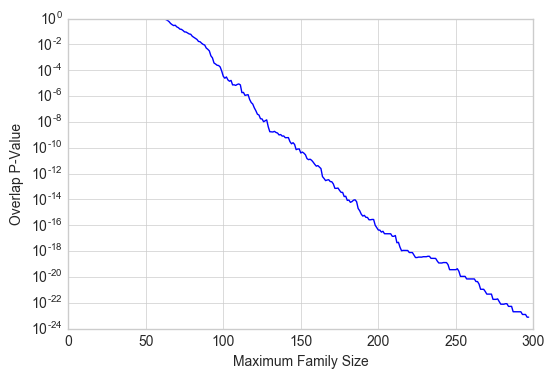

In [73]:
fig = plt.figure()
plt.semilogy(list(range(len(prob_line))), prob_line)
plt.ylabel("Overlap P-Value")
plt.xlabel("Maximum Family Size")

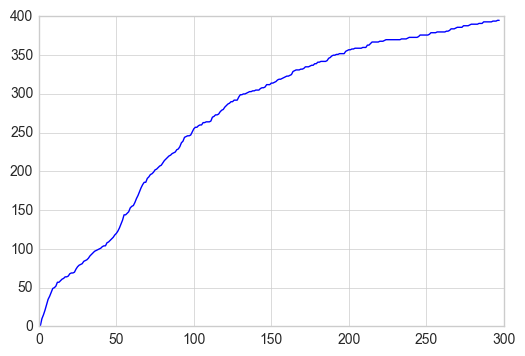

In [74]:
fig2 = plt.figure()
plt.plot(list(range(len(overlap_line))), overlap_line)

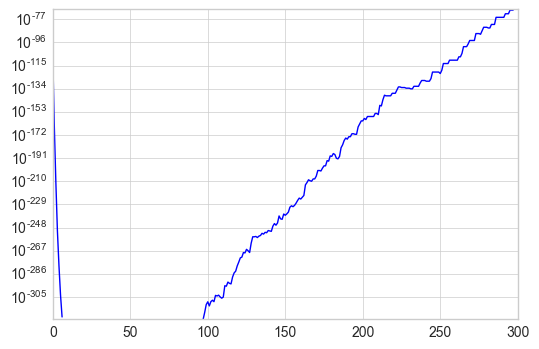

In [43]:
fig = plt.figure()
plt.semilogy(list(range(len(prob_line))), prob_line)

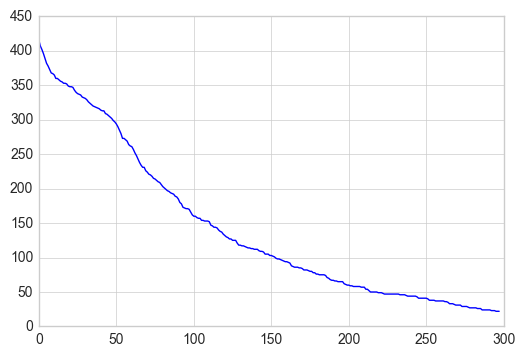

In [44]:
fig2 = plt.figure()
plt.plot(list(range(len(overlap_line))), overlap_line)